In [23]:
import math
import numpy as np
import pandas as pd
from sympy import var, solveset, S
from sympy import *
from sympy import Symbol
from scipy import interpolate
from matplotlib import pyplot as plt
# import mpl_axes_aligner

In [24]:
#Input Database

N = 7
Pc = np.array([673.3, 709, 617.4, 550.4, 487, 439.6, 260]) #in Psi
Tc = np.array([342.67, 549.67, 665.77, 765.27, 845.28, 913.392, 1116]) #in Rankine
w = np.array([0.011, 0.099, 0.153, 0.199, 0.251, 0.3, 0.65])
MW = np.array([16.04, 30.07, 44.1, 58.12, 72.15, 86.18, 210])
y = np.array([0.74,0.05,0.04,0.04,0.03,0.02,0.08])
#Input PT Condition
R = 10.731577089016
P = 2500
T = 180 

In [25]:
def ZBB(P,T):
  Pc = np.array([673.3, 709, 617.4, 550.4, 487, 439.6, 260]) #in Psi
  Tc = np.array([342.67, 549.67, 665.77, 765.27, 845.28, 913.392, 1116]) #in Rankine
  y = np.array([0.74,0.05,0.04,0.04,0.03,0.02,0.08])
  Ppc = 0
  Tpc = 0
  for i in range (N):
    Ppc += Pc[i]*y[i]
    Tpc += Tc[i]*y[i]
  Pr = P/Ppc
  Tr = (T+460)/Tpc
  A = 1.39*(Tr-0.92)**0.5-0.36*Tr-0.101
  A1 = (1-(1.39*(Tr-0.92)**0.5-0.36*Tr-0.101))/math.exp((0.62-0.23*Tr)*Pr+(0.066/(Tr-0.86)-0.037)*Pr**2+0.32/10**(9*(Tr-1))*Pr**6)
  A2 = (0.132-0.32*math.log(Tr,10))*Pr**(10**(0.3106-0.49*Tr+0.1824*Tr**2))
  return(A+A1+A2)

In [26]:
A =[]
for i in range (N):
  if w[i] <= 0.49:
    m = 0.37464+1.5422*w[i]-0.26992*w[i]**2
  elif w[i] > 0.49:
    m = 0.379642+1.48503*w[i]-0.164423*w[i]**2+0.016666*w[i]**3
  # a = 0.45724*R*R*Tc[i]*Tc[i]/Pc[i]*(1+m*(1-math.sqrt((T+459.67)/Tc[i])))**2/(R**2*(T+459.67)**2)*P
  a = (1+m*(1-math.sqrt((T+459.67)/Tc[i])))**2
  Ai = 0.45724*(P/Pc[i])/(((T+459.67)/Tc[i])**2)*a
  A.append(Ai)
print(A)

[0.35747566632037614, 1.0941377664385215, 2.05391952654238, 3.324284129774151, 4.931283258786364, 6.801618601467968, 22.997912388287038]


In [27]:
B = []
for i in range (N):
  b = 0.0778*(P/Pc[i])/((T+459.67)/Tc[i])
  B.append(b)
# print(B)

In [28]:
sigma_A = 0
sigma_B = 0
for i in range (N):
  for j in range (N):
    sigma_A += y[i]*y[j]*((A[i]*A[j])**0.5)
  sigma_B += y[i]*B[i]
print(sigma_A)
print(sigma_B)

1.2710894075660906
0.28920660578093815


In [29]:
c3 = 1
c2 = -(1-sigma_B)
c1 = sigma_A-3*sigma_B**2-2*sigma_B
c0 = -(sigma_A*sigma_B-sigma_B**2-sigma_B**3)
Z = var('Z', real=True)
result = list(solveset(c3*Z**3+c2*Z**2+c1*Z+c0, Z, domain=S.Reals))
z = result
z

[0.647856040243504]

In [30]:
MWa = 0
for i in range (N):
  MWa += MW[i]*y[i]
print("Specific Gravity (SG) = ", MWa/28.97) 

Specific Gravity (SG) =  1.3168795305488439


In [31]:
Bg = 0.0283* z[0]*(T+459.67)/P
print("Gas Formation Volume Factor =", Bg, "cu-ft/scf")

Gas Formation Volume Factor = 0.00469116730933221 cu-ft/scf


In [32]:
rho_g = 2.7*MWa/28.97*P/(z[0]*(T+459.67))
print("Gas Density =", rho_g, "lbm/cu-ft")

Gas Density = 21.4494087066703 lbm/cu-ft


In [33]:
def vis_g(T, MWa, rho):
  A = ((9.379+0.01607*MWa)*(T+459.67)**1.5)/(209.2+19.26*MWa+(T+459.67))
  B = 3.448+986.4/(T+459.67)+0.01009*MWa
  C = 2.447-0.2224*B
  return(A*exp(B*rho**C)/(10**4))
print("Gas Viscosity=", vis_g(T,MWa,rho_g/62.428), "cP")

Gas Viscosity= 0.0418730462012622 cP


In [34]:
print("Z Factor from Beggs-Brill Correlation is", ZBB(P,T))
print("It deviates for", abs(ZBB(P,T)-z[0])/ZBB(P,T)*100,"%")

Z Factor from Beggs-Brill Correlation is 0.6874658468246005
It deviates for 5.76171263838835 %


In [35]:
Bg_corr = 0.0283* ZBB(P,T)*(T+459.67)/P
Bg_corr

0.004977984469657469

# Probablistic Method to Determine Gas Reserve

In [36]:
import random
#Input the properties distribution
n = 10000
Area = np.random.uniform(300, 600, n)
Thickness = np.random.uniform(10, 15, n)
NTG = 1
POR = np.random.triangular(0.02, 0.15, 0.2, n)
SW = np.random.triangular(0.2, 0.3, 0.5, n)
BG= np.random.uniform(0.95*Bg_corr, 1.05*Bg_corr, n)
Feather = 1
OGIP = Area*Thickness*NTG*POR*(1-SW)/BG*43560*Feather/1000000000
classes=round(3.3*math.log(n,10),)
max(OGIP)

10.072057452886792

In [37]:
S = [[] for _ in range(classes)]
R = [[] for _ in range(classes)]
upper_limit = max(OGIP)
for i in range (len(OGIP)):
  if (0<OGIP[i]<(upper_limit/classes)):
    S[0].append(OGIP[i])
  elif ((upper_limit/classes)<OGIP[i]<(upper_limit/classes*2)):
    S[1].append(OGIP[i])
  elif((upper_limit/classes*2)<OGIP[i]<(upper_limit/classes*3)):
    S[2].append(OGIP[i])
  elif((upper_limit/classes*3)<OGIP[i]<(upper_limit/classes*4)):
    S[3].append(OGIP[i])
  elif ((upper_limit/classes*4)<OGIP[i]<(upper_limit/classes*5)):
    S[4].append(OGIP[i])
  elif((upper_limit/classes*5)<OGIP[i]<(upper_limit/classes*6)):
    S[5].append(OGIP[i])
  elif((upper_limit/classes*6)<OGIP[i]<(upper_limit/classes*7)):
    S[6].append(OGIP[i])
  elif ((upper_limit/classes*7)<OGIP[i]<(upper_limit/classes*8)):
    S[7].append(OGIP[i])
  elif((upper_limit/classes*8)<OGIP[i]<(upper_limit/classes*9)):
    S[8].append(OGIP[i])
  elif((upper_limit/classes*9)<OGIP[i]<(upper_limit/classes*10)):
    S[9].append(OGIP[i])
  elif ((upper_limit/classes*10)<OGIP[i]<(upper_limit/classes*11)):
    S[10].append(OGIP[i])
  elif((upper_limit/classes*11)<OGIP[i]<(upper_limit/classes*12)):
    S[11].append(OGIP[i])
  elif((upper_limit/classes*12)<OGIP[i]<(upper_limit)):
    S[12].append(OGIP[i]) 

interval = (upper_limit/classes)
bins = []
for i in range (classes):
  R[i] = str(round(i*interval,2)) + " - " + str(round(i*interval+interval,2))
  bins.append(i*interval)

In [38]:
f = []
w = []
cum_w = []
for i in range (classes):
  f.append(len(S[i]))
  w.append(len(S[i])/n)
  if i == 0:
    cum_w.append(w[i])
  else:
    cum_w.append(round(w[i]+cum_w[i-1],3))
# print(f)
# print(w)
# print(cum_w)

# Statistical Result

In [39]:
df = pd.DataFrame(np.column_stack([R,f,w,cum_w]), columns =['Gas Reserve (BSCF)','Frequency','w','W(x<xi)'])
pd.set_option('display.colheader_justify', 'center')
df

,Gas Reserve (BSCF),Frequency,w,W(x<xi)
0,0.0 - 0.77,29,0.0029,0.0029
1,0.77 - 1.55,465,0.0465,0.049
2,1.55 - 2.32,1080,0.108,0.157
3,2.32 - 3.1,1504,0.1504,0.307
4,3.1 - 3.87,1856,0.1856,0.493
5,3.87 - 4.65,1807,0.1807,0.674
6,4.65 - 5.42,1286,0.1286,0.803
7,5.42 - 6.2,923,0.0923,0.895
8,6.2 - 6.97,556,0.0556,0.951
9,6.97 - 7.75,288,0.0288,0.98


In [40]:
mid_val = []
for i in range (classes):
  x_new = round((i*interval)+(i*interval+interval),2)/2
  mid_val.append(x_new)
mid_val
f = interpolate.interp1d(cum_w, mid_val)
P90 = f(0.1)
P50 = f(0.5)
P10 = f(0.9)
print("P90: "+ str(P90) + " BSCF")
print("P50: "+ str(P50)+ " BSCF")
print("P10: "+ str(P10) + " BSCF")

P90:1.5259722222222223 BSCF
P50:3.5149723756906077 BSCF
P10:5.879196428571428 BSCF


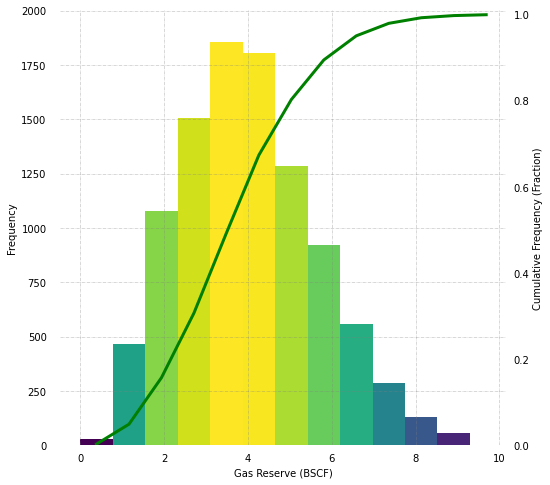

In [45]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
fig, ax = plt.subplots(figsize =(8, 8))
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
  
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
N, bins, patches = ax.hist(OGIP, bins = bins)
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

ax2 = ax.twinx()
# Remove x, y ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax2.plot(mid_val, cum_w, color='green',linewidth=3)
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
for s in ['top', 'bottom', 'left', 'right']:
    ax2.spines[s].set_visible(False)
# Show plot
# ax.margins(y=0.1)
ax2.margins(y=0.5)
# mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.01)
ax.set_ylim([0, 2001])
ax2.set_ylim([0, 1.01])
plt.xlabel("Pressure [psi]")
plt.ylabel("Gas Formation Volume Factor [cu-ft/scf]")
ax.set_xlabel('Gas Reserve (BSCF)')
ax.set_ylabel('Frequency')
ax2.set_ylabel('Cumulative Frequency (Fraction)')
plt.show()